In [1]:
# === Imports ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

# === Step 1: Load and Transform Dataset ===
file_path = "vroegtijdig-schoolverlaten-woonplaats-dataset-2022-2023.xlsx"
bad_df = pd.read_excel(file_path)

def transform_dataset(df):
    rows = []
    for _, row in df.iterrows():
        for i in range(row['vsv_noemer']):
            new_row = row.copy()
            new_row['vsv_teller'] = 1 if i < row['vsv_teller'] else 0
            rows.append(new_row)
    return pd.DataFrame(rows).drop(columns=['vsv_noemer'])

df = transform_dataset(bad_df)
df.drop(columns=['schooljaar'], inplace=True)

# === Step 2: Prepare X and y ===
X = df.drop(columns=['vsv_teller'])
y = df['vsv_teller']

In [2]:
# === Step 3: Train/Test Split ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [3]:
# === Step 4: Preprocessing Pipeline ===
categorical_cols = X.select_dtypes(include=['object']).columns
preprocessor = ColumnTransformer([
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), categorical_cols)
], remainder='passthrough')

In [4]:
# === Step 5: Model Training ===
model = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [5]:
# === Step 6: Global Metrics ===
global_cm = confusion_matrix(y_test, y_pred)
tn_global, fp_global, fn_global, tp_global = global_cm.ravel()
fpr_global = fp_global / (fp_global + tn_global)
fnr_global = fn_global / (fn_global + tp_global)

In [27]:
# === Step 7: Protected Group Detection ===
features_to_check = ['geslacht', 'belg_nietbelg', 'gezinstaal_nederlands', 'oki_waarde', 'woonplaats_provincie_naam']
results = []

for size in range(1, 4):
    for feat_combo in combinations(features_to_check, size):
        unique_values = [df[feat].unique() for feat in feat_combo]
        for value_combo in combinations([tuple(x) for x in pd.MultiIndex.from_product(unique_values)], 1):
            value_combo = value_combo[0]
            mask = (X_test[list(feat_combo)] == pd.Series(value_combo, index=feat_combo)).all(axis=1)
            if mask.sum() < 50:
                continue  # skip small groups
            y_sub = y_test[mask]
            y_pred_sub = y_pred[mask]
            cm = confusion_matrix(y_sub, y_pred_sub, labels=[0, 1])
            if cm.shape != (2, 2):
                continue
            tn, fp, fn, tp = cm.ravel()
            fpr = fp / (fp + tn) if (fp + tn) else 0
            fnr = fn / (fn + tp) if (fn + tp) else 0
            results.append({
                'group': f"{dict(zip(feat_combo, value_combo))}",
                'size': len(y_sub),
                'fpr': round(fpr, 3),
                'fnr': round(fnr, 3),
                'fpr_diff': round(fpr - fpr_global, 3),
                'fnr_diff': round(fnr - fnr_global, 3)
            })

C:\Users\mouni\AppData\Local\Temp\ipykernel_5952\343076892.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


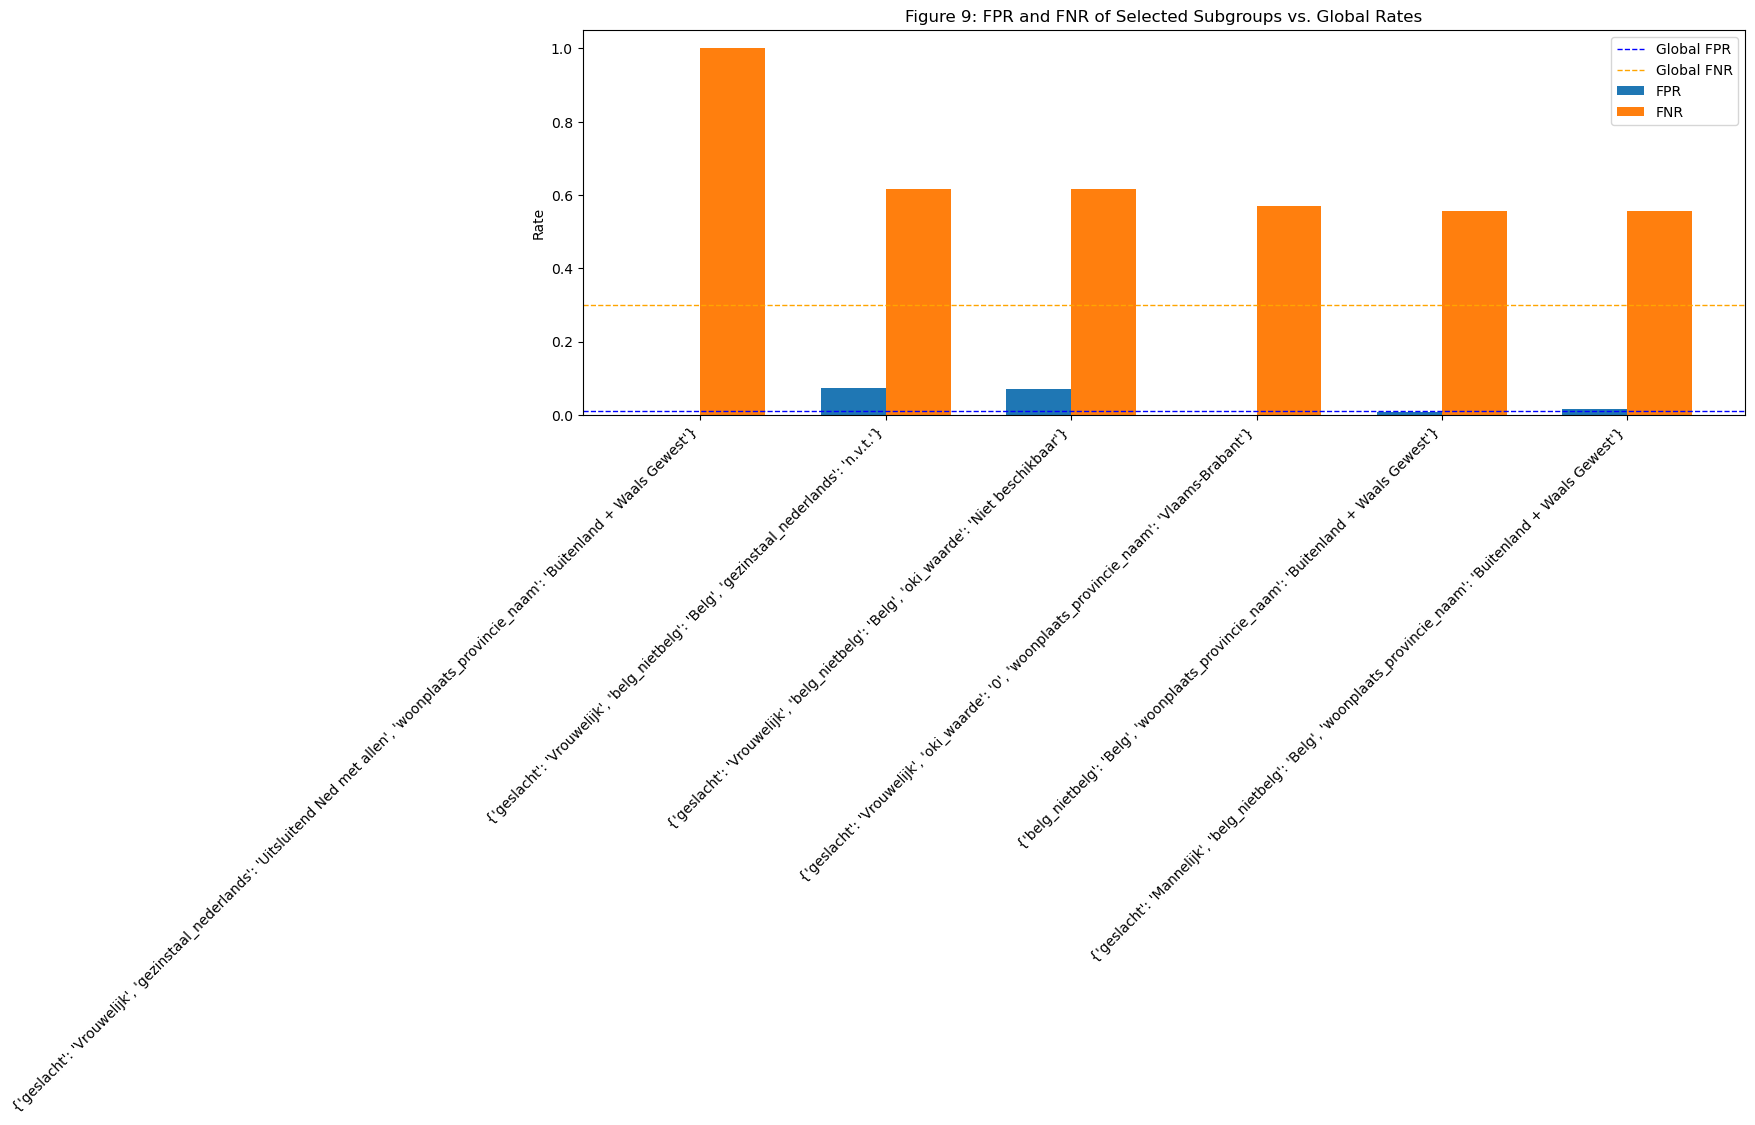

In [29]:
# === Step 8: Visualize Top Deviating Groups ===
df_results = pd.DataFrame(results)
top_results = df_results.sort_values(by='fnr_diff', ascending=False).head(6)

plt.figure(figsize=(15, 5))
bar_width = 0.35
x = range(len(top_results))
plt.bar(x, top_results['fpr'], width=bar_width, label='FPR')
plt.bar([i + bar_width for i in x], top_results['fnr'], width=bar_width, label='FNR')
plt.xticks([i + bar_width / 2 for i in x], top_results['group'], rotation=45, ha='right')
plt.axhline(y=fpr_global, color='blue', linestyle='--', linewidth=1, label='Global FPR')
plt.axhline(y=fnr_global, color='orange', linestyle='--', linewidth=1, label='Global FNR')
plt.title("Figure 9: FPR and FNR of Selected Subgroups vs. Global Rates")
plt.ylabel("Rate")
plt.legend()
plt.tight_layout()
plt.show()